In [1]:
import pandas as pd
from prophet import Prophet
from datetime import date, timedelta, datetime
import plotly.express as px

In [2]:
confirmed_global_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
confirmed_global_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/22,3/11/22,3/12/22,3/13/22,3/14/22,3/15/22,3/16/22,3/17/22,3/18/22,3/19/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,175893,175974,176039,176201,176409,176571,176743,176918,176983,177039
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,272479,272552,272621,272663,272689,272711,272804,272885,272961,273040
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,265366,265391,265410,265432,265457,265478,265496,265511,265524,265539
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,38794,38794,38794,38794,38794,38794,38794,39234,39234,39234
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,98855,98855,98909,98927,98931,98956,98985,99003,99003,99003


In [3]:
country_main = 'Germany'
confirmed_global_df = confirmed_global_df[confirmed_global_df['Country/Region'] == country_main].reset_index(drop=True)
confirmed_global_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/10/22,3/11/22,3/12/22,3/13/22,3/14/22,3/15/22,3/16/22,3/17/22,3/18/22,3/19/22
0,NaN,Germany,51.165691,10.451526,0,0,0,0,0,1,...,16814429,17051518,17198365,17271708,17470663,17732946,18027870,18325720,18585957,18717682


In [4]:
confirmed_global_df.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)
df = pd.melt(confirmed_global_df, id_vars=['Country/Region'], value_vars=confirmed_global_df.columns[1:])
df.drop(['Country/Region'], axis=1, inplace=True)

In [5]:
#convert the values to contain new cases per day
df['ds'] = df['variable'].apply(lambda x: datetime.strptime(str(x), "%m/%d/%y"))
df.drop(['variable'], axis=1, inplace=True)
df['value'] = df['value'].diff()
df.loc[0,'value'] = 0
df.columns = ['y', 'ds']

# Training

In [6]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
m.fit(df)

Initial log joint probability = -11.2231
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1736.75     0.0450445       305.608           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1745.37   0.000228708       79.6086           1           1      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1752.11    0.00462243       92.7721       3.341      0.8141      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       1752.18   2.25727e-05        81.126   2.543e-07       0.001      483  LS failed, Hessian reset 
     374       1752.19   8.91068e-08       68.1972      0.7739      0.7739      517   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [7]:
future = m.make_future_dataframe(periods=365,freq='D')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,-3479.597100,-53992.808079,48093.351901,-3479.597100,-3479.597100,-774.847099,-774.847099,-774.847099,-13950.584187,...,10265.023323,10265.023323,10265.023323,2910.713765,2910.713765,2910.713765,0.0,0.0,0.0,-4254.444199
1,2020-01-23,-3363.090303,-49579.565843,45754.234647,-3363.090303,-3363.090303,-349.634710,-349.634710,-349.634710,-13950.584187,...,8116.530599,8116.530599,8116.530599,5484.418878,5484.418878,5484.418878,0.0,0.0,0.0,-3712.725014
2,2020-01-24,-3246.583506,-57208.902163,39895.140902,-3246.583506,-3246.583506,-3753.428316,-3753.428316,-3753.428316,-13950.584187,...,2222.834061,2222.834061,2222.834061,7974.321810,7974.321810,7974.321810,0.0,0.0,0.0,-7000.011822
3,2020-01-25,-3130.076709,-59514.490283,36966.003034,-3130.076709,-3130.076709,-10178.971373,-10178.971373,-10178.971373,-13950.584187,...,-6581.377026,-6581.377026,-6581.377026,10352.989840,10352.989840,10352.989840,0.0,0.0,0.0,-13309.048082
4,2020-01-26,-3013.569912,-64379.138608,34446.425466,-3013.569912,-3013.569912,-14951.038032,-14951.038032,-14951.038032,-13950.584187,...,-13594.663695,-13594.663695,-13594.663695,12594.209851,12594.209851,12594.209851,0.0,0.0,0.0,-17964.607944


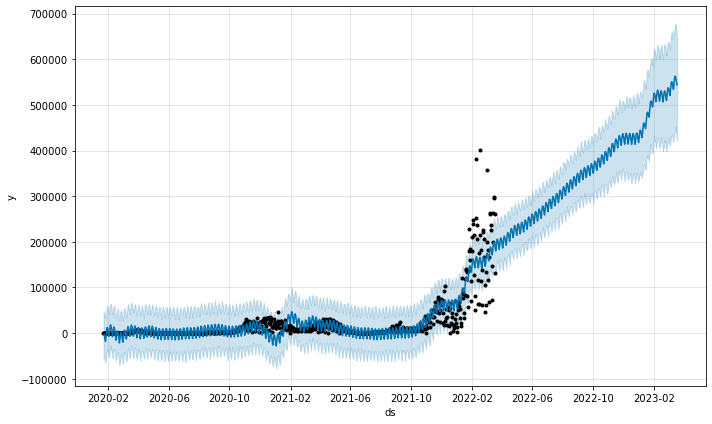

In [8]:
plot1 = m.plot(forecast)

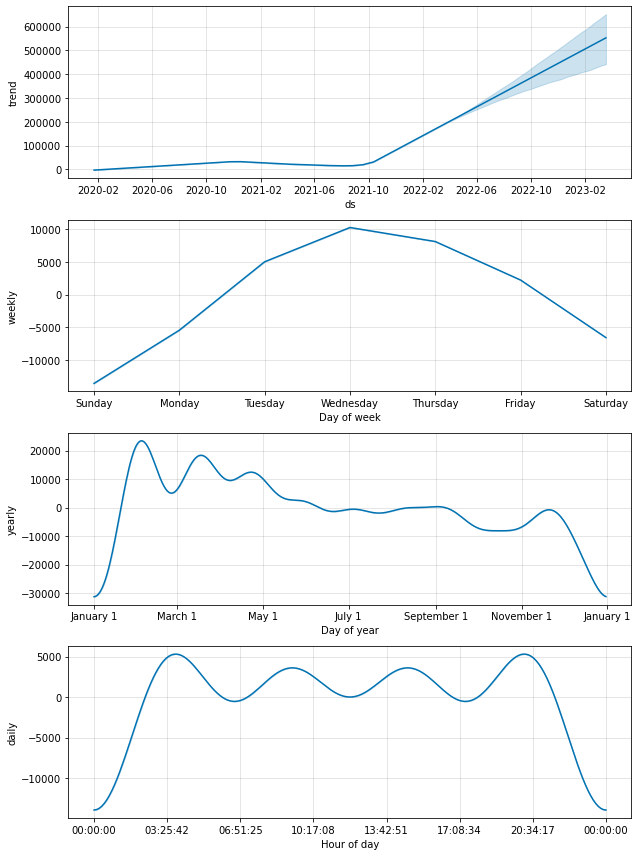

In [9]:
# Seasonality by timeframe
plt2 = m.plot_components(forecast)

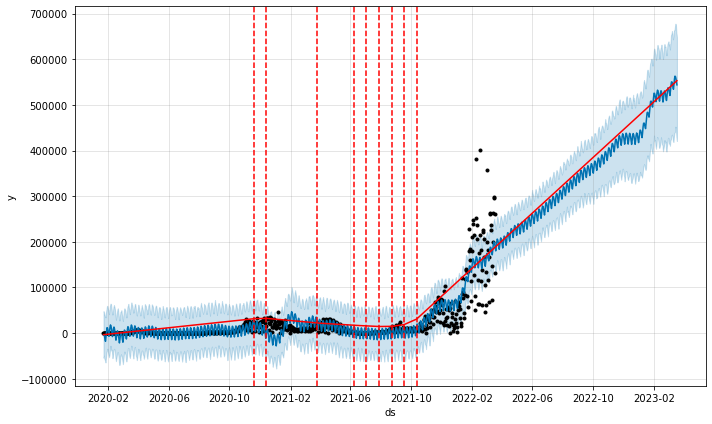

In [10]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# Holidays

In [11]:
holidays_df = pd.read_csv('holidays_df_of_70_countries_for_covid_19_2022_Temporary.csv')
germany_holidays = holidays_df[holidays_df['country'] == country_main]

In [12]:
germany_holidays.drop(['ds', 'country', 'code', 'country_official_name', 'prior_scale', 'source'], axis=1, inplace=True)

/Users/yevheniyavytruchenko/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [13]:
germany_holidays.columns= ['ds', 'holiday', 'lower_window', 'upper_window']
germany_holidays

,ds,holiday,lower_window,upper_window
509,2020-04-10,Karfreitag,-3,3
510,2020-04-13,Ostermontag,-3,3
511,2020-05-01,Erster Mai,-3,3
512,2020-05-21,Christi Himmelfahrt,-3,3
513,2020-06-01,Pfingstmontag,-3,3
514,2020-10-03,Tag der Deutschen Einheit,-3,3
515,2020-12-25,Erster Weihnachtstag,-3,3
516,2020-12-26,Zweiter Weihnachtstag,-3,3
517,2021-01-01,Neujahr,-3,3
518,2021-04-02,Karfreitag,-3,3


In [14]:
m = Prophet(holidays=germany_holidays)
m.add_country_holidays(country_name='DE')
forecast = m.fit(df).predict(future)

/Users/yevheniyavytruchenko/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.2231
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1743.48     0.0018234       98.4294      0.8131      0.8131      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1754.23    0.00285786       146.326      0.8145      0.8145      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1757.39     0.0144072       91.7611           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     364       1758.16   0.000335522        63.586   4.102e-06       0.001      487  LS failed, Hessian reset 
     399       1758.19   7.23887e-06       68.6414       1.383      0.1383      540   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     471        1759.3   0.000301561    

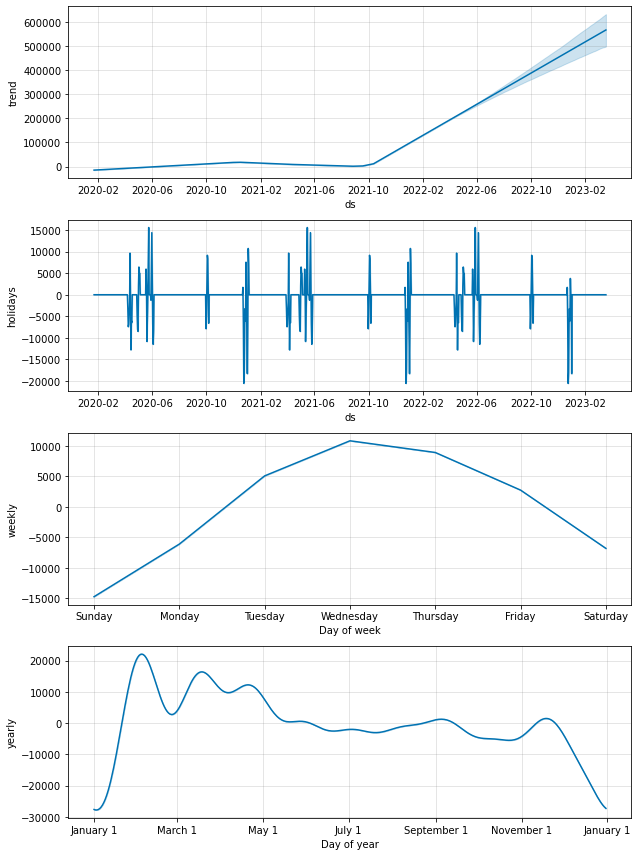

In [15]:
fig = m.plot_components(forecast)

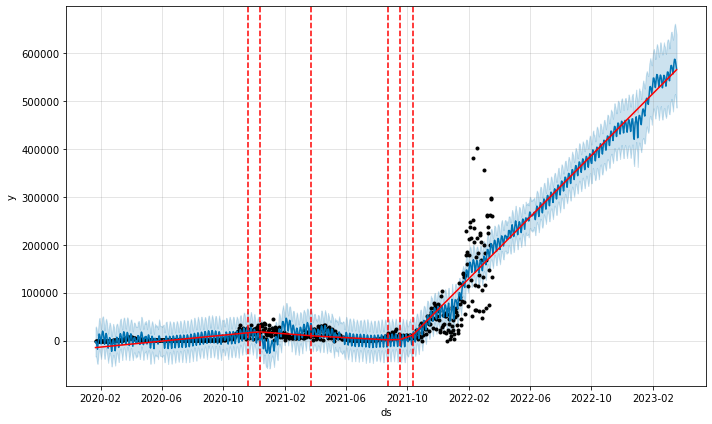

In [16]:
plot_with_holidays = m.plot(forecast)
a = add_changepoints_to_plot(plot_with_holidays.gca(), m, forecast)